In [1]:
import random
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
from importlib import reload

import gym
import matplotlib.pyplot as plt
import wandb
import torch

from Learning.utils import ReplayBuffer, plot, plot_test_trajectory, PER_IS_ReplayBuffer
import Learning.agents as ag
import Envs.AYS.AYS_Environment as ays

In [11]:
UPDATE_ONLINE = False
BATCH_SIZE = 256
MAX_EPISODES = 2000
RANDOM_EXPERIENCE = 0
LEARNING_RATE = 3e-4
BUFFER_SIZE = 2**14
REWARD_TYPE = 'PB'
DT = 1
SCHEDULER = (False, 1000, 0.5)
SEED = 0
MAX_STEPS = 600

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

wandbsave = False

config = {
    "learning_rate": LEARNING_RATE,
    "max_episodes": MAX_EPISODES,
    "batch_size": BATCH_SIZE, 
    "online_updating": UPDATE_ONLINE,
    "random_experience": RANDOM_EXPERIENCE,
    "buffer_size": BUFFER_SIZE,
    "reward_type": REWARD_TYPE,
    "dt": DT,
    "scheduler": SCHEDULER,
    "seed": SEED
}
reload(ays)
env = ays.AYS_Environment(discount=0.99,dt=DT, reward_type=REWARD_TYPE)
state_dim = len(env.observation_space)
action_dim = len(env.action_space)

reload(ag)
memory = PER_IS_ReplayBuffer(BUFFER_SIZE, alpha=0.6)
agent = ag.A2C(state_dim, action_dim, alpha=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(agent.optimizer, step_size=SCHEDULER[1], gamma=SCHEDULER[2])

if wandbsave:
    wandb.init(name="AYS_PPO2_policy_cost",config=config,
               entity="climate_policy_optim",  project="AYS_learning")
    wandb.watch(agent.ac_net)

Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


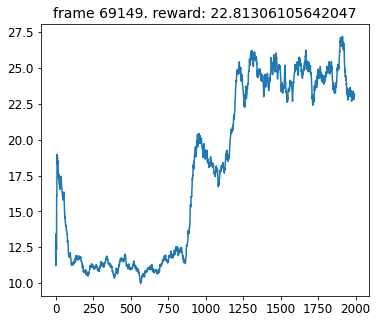

In [12]:
rewards = []
mean_rewards = []
frame_idx = 0
beta = 0.6

for episodes in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    episode_reward = 0
    done = False

    for i in range(MAX_STEPS):
        if episodes>RANDOM_EXPERIENCE:
            action = agent.get_action(state)
        else:
            action = np.random.choice(action_dim)
            
        next_state, reward, done,  = env.step(action)
        
        
        episode_reward += reward
        
        if UPDATE_ONLINE:
            loss = agent.online_update((state, action, reward, next_state, done))
            if wandbsave:
                wandb.log({'loss': loss})
        else:
            memory.push(state, action, reward, next_state, done)
            
        
        state = next_state
        frame_idx += 1 
        if done:
            break
        
    rewards.append(episode_reward)
    mean_rewards.append(np.mean(rewards[-50:]))
    
    if not UPDATE_ONLINE:
        if memory.size > BATCH_SIZE:
            beta = 1-0.4*np.exp(-0.001*episodes) # we converge beta to 1
            sample = memory.sample(BATCH_SIZE, beta)
            loss, tds = agent.update((sample['obs'], sample['action'], sample['reward'], sample['next_obs'], sample['done']))
            new_tds = np.abs(tds.cpu().numpy()) + 1e-6 # compatibility
            memory.update_priorities(sample['indexes'], new_tds)
            if wandbsave:
                wandb.log({'loss': loss})    
                
    if SCHEDULER[0]:
        scheduler.step()
    
    if wandbsave:
        wandb.log({'episode_reward':episode_reward})
        if episodes%200==0:
                plot_test_trajectory(env, agent)
            
    else:
        if episodes%10==0:
            plot(frame_idx, mean_rewards)
            if episodes%30==0:
                plot_test_trajectory(env, agent)

if wandbsave:
    wandb.run.summary["mean_reward"] = np.mean(rewards)
    wandb.run.summary["top_reward"]= max(rewards)
    wandb.finish()

In [ ]:
plot_test_trajectory(env, agent)

In [2]:
from learning_loop import learning_loop_wandb_hparam

In [6]:
sweep_config = {
  "name" : "A2C_sweep_bayes",
  "method" : "bayes",
  "parameters" : {
    "discount": {
      "min" : 0.5,
      "max": 0.999
    },
    "lr" :{
      "min": 0.00001,
      "max": 0.01
    },
    "beta":{
        "min":0.,
        "max":0.5
    },
    "buffer_size": {
        "values": [1000, 5000, 10000, 50000, 100000]
    },
    "batch_size":{
        "values": [16, 32, 64, 128, 256,]
    },
    "random_exp":{
        "values": [0, 250, 500]
    }
  }
}

metric = {
    'name': 'mean_reward',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric
sweep_id = wandb.sweep(sweep_config, project="AYS_learning")

Create sweep with ID: 1f1ehogx
Sweep URL: https://wandb.ai/climate_policy_optim/AYS_learning/sweeps/1f1ehogx


In [ ]:
wandb.agent("1f1ehogx" , function=learning_loop_wandb_hparam, project="AYS_learning")

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0z1yio03 with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.12537018690748475
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9674353729322756
wandb: 	lr: 0.003289604869274516
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: theowolf (climate_policy_optim). Use `wandb login --relogin` to force relogin


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▇▄▅▅▄▄▅▄▄▅▄▃▅▅▅▆▇█▄▆▆▂▅▄▆▅▆▆▅▆▄▇▅▆▅▃▅▆▄
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█████▁███▁▁
loss,-0.7175
mean_reward,80.73829
reward,40.94089


wandb: Agent Starting Run: zfmvi3yh with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.06846250680709343
wandb: 	buffer_size: 5000
wandb: 	discount: 0.989354715392791
wandb: 	lr: 0.0033476744907012437
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▂▂▂▂▂▁▁▂▁▁▅▃▃▁█▁▁▅▁▄▁▁▂▁▆▁▁▄▁▁▁▂▁█▁▁▃▂▂▂
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁██▇▇▇▇▁▇▁▁█▇▁
loss,20.51376
mean_reward,112.82994
reward,117.4298


wandb: Agent Starting Run: lu6qc3ak with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.13380133764006025
wandb: 	buffer_size: 1000
wandb: 	discount: 0.9748836189522682
wandb: 	lr: 0.0006677350295121047
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▄▄▃▂▂▂▁▂▃▃▃▃▃▂▃▃▃▅▃▄▅▃▃▄▃▄▃▂▂▂█▃▇▂▃▄▂▃▃▃
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁█████▁▁▁██▁▁█▁
loss,0.32291
mean_reward,95.3799
reward,51.68329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1851lxb7 with config:
wandb: 	batch_size: 16
wandb: 	beta: 0.05585729568632475
wandb: 	buffer_size: 1000
wandb: 	discount: 0.951528127602196
wandb: 	lr: 0.0019996275873068255
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▄▆▇▇▅▅▆▇▄▅▁▆▇▄▄▆▆▅▆▅▇▁▅▇▆▅▆▆▅▆█▆▅▅▅▅▆▅▆▅
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,-0.14906
mean_reward,27.22131
reward,0.0


wandb: Agent Starting Run: xnezkijw with config:
wandb: 	batch_size: 64
wandb: 	beta: 0.1233808862098833
wandb: 	buffer_size: 50000
wandb: 	discount: 0.9370131832248612
wandb: 	lr: 0.002109932458757685
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,██▇▃▁▆▄▄▄▆▄▅▅▄▂▅▅▄▄▅▅▇▄▆▅▆▄▅▅▅▅▅▅▅▅▅▂▄▄▄
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▁▁▁▁▇▇▇▇▁▁▁▁▁
loss,-1.07174
mean_reward,36.18452
reward,21.56313


wandb: Agent Starting Run: 2629d28y with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.3981126881355194
wandb: 	buffer_size: 10000
wandb: 	discount: 0.6302028883236309
wandb: 	lr: 0.003034960429523614
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▆▅█▄▅▄▄▅▃▄▃▃▃▅▄▄▅▄▄▃▃▂▃▄▂▅▁▃▂▃▂▃▆▃▄▂▄▆▄
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,-0.52554
mean_reward,18.46117
reward,0.0


wandb: Agent Starting Run: kvb3kqf4 with config:
wandb: 	batch_size: 16
wandb: 	beta: 0.15611878612250774
wandb: 	buffer_size: 50000
wandb: 	discount: 0.9803145600007388
wandb: 	lr: 0.004847272381712622
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▆▇▅▇▄▅▄▇▇▆▅▆▄█▅▅▄▄▄█▆▅▃▄▃▁▃▇▂▄▄▂▁▄▄▄▃▅▃▃
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁██▁█▁
loss,-0.92239
mean_reward,49.9343
reward,66.49627


wandb: Agent Starting Run: 8gdiu2vt with config:
wandb: 	batch_size: 32
wandb: 	beta: 0.17002654892985275
wandb: 	buffer_size: 100000
wandb: 	discount: 0.6605383458564094
wandb: 	lr: 0.0007549502953206812
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▇█▇▆▄▇▇▇█▇█▇▇█▇██▇▇█▇▄█▇▅▇▇▇▇█▇▇▁▇█▇▇▇▇▇
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,-0.22544
mean_reward,20.2253
reward,0.0


wandb: Agent Starting Run: v5lpxaws with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.19320768476190636
wandb: 	buffer_size: 1000
wandb: 	discount: 0.9416909379878102
wandb: 	lr: 0.003760664338520914
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▆▆▃▃▅▃▁▂▅▄▄▄▂▄▃▄▃▃▄▂█▄▄▄▄▄▄▄▄▃▄▄▄▃▃▄▄▅▄▄
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁██▁▁▁█▁▁
loss,-0.09088
mean_reward,53.66666
reward,23.29715


wandb: Agent Starting Run: i8nxieu0 with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.1299908193368503
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9960188369903464
wandb: 	lr: 0.0014188688445248984
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▆█▁██▇▇██▁██
loss,0.8741
mean_reward,123.2548
reward,107.26935


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1cs7fpjo with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.10905401189677484
wandb: 	buffer_size: 1000
wandb: 	discount: 0.93307333540052
wandb: 	lr: 0.0026286854075995986
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▇▃▂▁▅▁▃▃▂▂▄▄▃▃▄▁▄▅▄▄▄▅▆▃▂▃▄▁▃▂▆▃▃▄█▄▁▃▂▃
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁███▁▁█▁
loss,0.31184
mean_reward,61.71939
reward,0.0


wandb: Agent Starting Run: ftc4eh7r with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.03910711445179327
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9880471716824468
wandb: 	lr: 0.0023397897938881246
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▂▂▁▁▂▅▁▂█▁▃▂▁▅▅▂▂▇▁▁▂▁▁▁▆▄▂▁▁▇▅▂▂▄▃▃▄▁▂▂
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁█▁▁████▁█▁█▁█▁▁███▁▁▁█
loss,1.08674
mean_reward,146.55212
reward,0.0


wandb: Agent Starting Run: os7eihag with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.07732820506366989
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9788469280570936
wandb: 	lr: 0.0010117980483131763
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▃▃▂▁▃▂▂▂▂▂▅▂▃▂▂▅▃▃▂▂▂▂▂▂▂▃█▂▂▃▅▂▄▃▃▅▂▃▃▂
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁██▁▁▁▁█▁████▁▁▁██▁▁▁█
loss,-0.23964
mean_reward,156.27387
reward,62.25849


wandb: Agent Starting Run: uzkawomj with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.12428520251899232
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9955856482769768
wandb: 	lr: 0.0031650119671844425
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁█
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▆▁▁▁▆▁▁▁█▁▇
loss,0.86389
mean_reward,133.61261
reward,147.36119


wandb: Agent Starting Run: 5dgeiivc with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.2793738340251123
wandb: 	buffer_size: 50000
wandb: 	discount: 0.9834014529544752
wandb: 	lr: 0.003756146945421714
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▃▃▃▃▃▃▃▂▄▃▃▂▁▂▄▅▃▁▁▁▂▂█▁▂▃▃▂▂▂▃▂▂▂▃▂▃▇▃▂
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁██▁
loss,2.02886
mean_reward,66.94372
reward,77.90861


wandb: Agent Starting Run: vim5ovcy with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.06008523701222929
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9608673339374828
wandb: 	lr: 0.0014495278481874178
wandb: 	random_exp: 500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▆▄▃▅▅▁▃▃▄▂▂▅▅▃▅▄▃▅▇▄▅▄▇▄▅▄█▄▄▄▇▄▃▄▆▅▅▆▆▅
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▁███▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,-0.54825
mean_reward,78.54569
reward,1.2415


wandb: Agent Starting Run: b3wibhfw with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.1833554851987367
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9496955480570116
wandb: 	lr: 0.003165337931040922
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▆▅▇▅█▁▄▄▄▅▅▄▅▅▆▅▅▅▅▅▄▅▄▅▄▅▅▄▅▅▅▅▅▄▅▅▅▄▅▄
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁█
loss,-0.35443
mean_reward,101.55566
reward,26.67955


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: crwg8778 with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.09707989525599776
wandb: 	buffer_size: 50000
wandb: 	discount: 0.9723955572121814
wandb: 	lr: 0.001154025782371909
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▅▄▃▄▃▃▄▁▄▃▂▃▃▃▂▂▂▂▇▃▃█▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▄▃
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████▁▁▁███▁█▁▁█▁██▁▁█▁
loss,0.00535
mean_reward,152.8644
reward,48.06393


wandb: Agent Starting Run: fmi9a97s with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.034820138263261746
wandb: 	buffer_size: 100000
wandb: 	discount: 0.9934038066612476
wandb: 	lr: 0.0005070230533762984
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▃▂▁▂▂▂▁▁▂▁▁▂▂▂▂▁▂▄▂▁▄█▅▂
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇▆▇▇▇▁▁██▁███████▁██▁█
loss,0.68499
mean_reward,212.56416
reward,174.62453


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rts6sscb with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.013878339118527427
wandb: 	buffer_size: 50000
wandb: 	discount: 0.8569303983514733
wandb: 	lr: 0.0008658510645890922
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▅▄▁▃▇▅▆▄▆▆▅▆█▆▆▆▇▇▇▅▆▆▇██▅██▇▅▆▇▇▇▇▇▇█▇▇
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁████▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁██
loss,-0.0979
mean_reward,87.53225
reward,10.31949


wandb: Agent Starting Run: ovj15ywg with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.050169582015354375
wandb: 	buffer_size: 100000
wandb: 	discount: 0.9983528412428408
wandb: 	lr: 0.0015729787274954305
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▁▁▁▁▂▁▁▃▂▃▁▁▁▁▂▁▁▂▁▁▂▂▁█▃▁▁▁▇▄▁▁▁▁▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇█▇██▁▁▁
loss,15.36763
mean_reward,147.77865
reward,0.0


wandb: Agent Starting Run: zaj807kb with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.25713490929210303
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9884355459614634
wandb: 	lr: 0.0024656948718059075
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▂▁▂▁▁▁▃▂▁▂▁▁▁▂▂▁▃▃▁▄▁▁▁█▁▂▁▁▁▂▃▁▃▁▁▁▂▃▁
mean_reward,▁
reward,▁▁▁█▁████▁▁███▇▇▁▁▇█▁▁▁▁█▁▁█▁▁▁▁█████▁██
loss,5.37616
mean_reward,225.03954
reward,109.70604


wandb: Agent Starting Run: wc4k6xm6 with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.3703006373250563
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9542502563640964
wandb: 	lr: 0.00046496849127086466
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.


loss,▇▆▆▂▅▁▅▅▅▅▆▄▆▅▇▅▄▅▄▄▃▃▅▅▄▄▆█▄▅▅▅▅▃▄▄▃▅▅▅
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
loss,-0.57507
mean_reward,52.26247
reward,1.3555


wandb: Agent Starting Run: 435uc8mu with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.1153473717100748
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9754433030807664
wandb: 	lr: 0.0038304571526381168
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▄▁▂▃▃▂█▃▃▃▃▂▂▃▃▃▃▅▃▃▃▃▃▃▄▅▃▃▃▃▂▃▃▇▅▅▃▃▃▃
mean_reward,▁
reward,▁▁▁▁▁▁▁▁███▁█▁▁█▁▁▁▁█▁▁▁▁███████▁▁█▁██▁▁
loss,0.09487
mean_reward,159.90473
reward,53.83115


wandb: Agent Starting Run: 3oajef1t with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.2788388352456155
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9452478815265408
wandb: 	lr: 0.005407138947731819
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▅▅▅▄▇▂▆▄▃█▆▅▃▅▅▆▄▂▅▅▅▇▃▆▆▁▃▆▄▃▅▄▃▄▅▆▄▅▄▅
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁█
loss,-0.17431
mean_reward,24.85376
reward,0.0


wandb: Agent Starting Run: supkwycv with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.28403181153416834
wandb: 	buffer_size: 5000
wandb: 	discount: 0.9680561199336396
wandb: 	lr: 0.004638171673147082
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▅▄▂▆▄▂▃▄▄▃▄▃▃▃▇▃▃▄▃▃▄▆▆▄▄▁█▃▃▄▂▃▄▄▃▃▃▆▄▄
mean_reward,▁
reward,▁▁▁██▁█▁█▁██▁█▁█▁▇█▁▁▁▁█▁▁▁█▁▁█▁█▁▁▁█▁██
loss,-0.46295
mean_reward,151.18094
reward,41.74334


wandb: Agent Starting Run: k4sa639i with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.2295145172147108
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9056446572348648
wandb: 	lr: 0.0028641280537962843
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▄▃▃▃▃▃▃▂▂▃▄█▃▂▂▂▃▃▃▃▃▁▃▂▃▂▂▃▃▅▄▁▂▃▃▃▄▃▂▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▇▇▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁
loss,-0.46523
mean_reward,30.42958
reward,0.74335


wandb: Agent Starting Run: uxas2ddg with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.31000059384987444
wandb: 	buffer_size: 100000
wandb: 	discount: 0.998714069461922
wandb: 	lr: 0.002150705375273407
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▄▁▁▂▁▂▁▂▁▃▃▄▆▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁█▁▁▁▁
loss,118.49368
mean_reward,70.6384
reward,344.62171


wandb: Agent Starting Run: cqf9n7ce with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.1658500966940078
wandb: 	buffer_size: 100000
wandb: 	discount: 0.968952584612408
wandb: 	lr: 0.0012104648667955002
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▇▆▅▆▄▄▅▁▅▆▃▅▅▅▅▄▄▄▄▄▄▅▄▅█▄▄▅▄▅▆▅▄▅▅▆▅▅▅▄
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████▁▁██▁██▁████▁██▁▁
loss,-0.8895
mean_reward,157.45083
reward,42.94682


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: acchgrnd with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.22061200769078793
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9924804521955678
wandb: 	lr: 0.0022921681576678903
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▁▁▁█▁▅▁▂▁▇▂▁▃▁▁▁▁▇▁▁▃▁▄▁▁▁▃▁▅▃▄▁▃▁▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▅▁▁▁▇▁▆▁▁█▁█▁██▁▁█▁▁▁█
loss,-1.49824
mean_reward,166.41087
reward,154.06882


wandb: Agent Starting Run: vq520bfh with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.2846422390689911
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9900724433317236
wandb: 	lr: 0.0020375567422740836
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▆▂▁▂▁▁▁▆▁▁▁▁▁▁▁▁▁▁▃▁▃▁▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▇▁▁▁▁▁██▁▁▇█▁██▁█▁▇▁█▇▇█▁
loss,-0.50384
mean_reward,236.14938
reward,102.10104


wandb: Agent Starting Run: kg36bscp with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.2937160215834494
wandb: 	buffer_size: 10000
wandb: 	discount: 0.9414616557249104
wandb: 	lr: 0.004793694404360473
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▆█▇▇▄▅▅▄▆▅▅▆▄▅▅▆▅▄▅▄▆▅▆▆▅▆▆▅▂▇▇▄▁▆▄▆▅▅▅▅
mean_reward,▁
reward,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,-0.16428
mean_reward,34.9956
reward,0.0


wandb: Agent Starting Run: whv0ryz3 with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.18184195103111803
wandb: 	buffer_size: 50000
wandb: 	discount: 0.9977004654590258
wandb: 	lr: 7.848165138371038e-05
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▁▁▁▄▁▂▂█▂▃▁▃▃▁▁▂▁▃▄▂▁▁▁▃▁▁▃▁▁▁▂▁▁▁▁▁▆▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁████▁▁▁▁▁▁▁▁▁▁▁█▁▁
loss,176.32713
mean_reward,115.73525
reward,286.28125


wandb: Agent Starting Run: uidzb7ah with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.21121724670187003
wandb: 	buffer_size: 10000
wandb: 	discount: 0.981886884444158
wandb: 	lr: 0.0015298543300956585
wandb: 	random_exp: 250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▂▃▂▂▁▃▁▇▃█▂▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▄▂▃▂▄▂▂▂▂▂▄▄▃
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁█▁███▁█▁███▁██▁▁▁▁█▁▁█
loss,-0.54769
mean_reward,141.87705
reward,72.36231


wandb: Agent Starting Run: 0uwy0nee with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.15704787123820624
wandb: 	buffer_size: 50000
wandb: 	discount: 0.9787016717529736
wandb: 	lr: 0.0017657721172221184
wandb: 	random_exp: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


loss,▁▁▂▂▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁█▂▁▁▁▁▁▂▂▁▁▄▂▃▂▁▂▂▁▃▁
mean_reward,▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁██▁████▁▁██▁██
loss,-0.03983
mean_reward,142.34948
reward,61.54466


wandb: Sweep Agent: Waiting for job.
